## Header

In [1]:
from __future__ import division
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from lmfit import Model, conf_interval, ci_report
from cells_new import intensity_ambmcp, set_standard_constraints, setfix, calc_eta, get_cell_1R, get_cell_2R,get_cell_1L,get_cell_2L
from cells_new import set_rotation_domains,orthorhombic_only
from pprint import pprint
%matplotlib nbagg

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Fixed values

In [16]:
# 'In-plane' for a-a+c-. Determine this from measuring (1 1/2 3/2), (1/2 1 3/2), and (1/2 3/2 1) or similar.
# For in plane: D_2Rpmp -> D_2Lpmp,  D_1Lppm -> D_1Rpmp,  D_1Rpmp -> D_1Lpmp, D_2Lppm -> D_2Rppm
# Other 4 domains same as out-of-plane

# Set values for lattice, including symbols for the elements for the form factors. Also must indicate rotation type.
Rotations = 'Out-of-plane'
#Rotations = 'In-plane'

constants = OrderedDict([('a',4.), ('b',4.), ('c',4.), ('symbols',np.array(['La3+','V3+','O2-'])),
                         ('wavelength',1.), ('I0',1),('Rot_type',np.array([Rotations]))])



## Setup model

In [17]:
# For fitting, takes the intensity function, and H,K,L, and eta as the independent variables, along with the constants.
May_model = Model(intensity_ambmcp, independent_vars=['H', 'K', 'L', 'eta'] + constants.keys())
params = May_model.make_params()

# Setup initial guesses

In [18]:
# Input guesses for the rotation angles, A-site displacements, and the volume fractions.
#D_2Rpmp -> D_2Lpmp,  D_1Lppm -> D_1Rppm,  D_1Rpmp -> D_1Lpmp, D_2Lppm ->D_2Rppm 
guesses = OrderedDict([('alpha', 6.), ('beta', 6.), ('gamma', 6.), ('d1', 0.015), ('d2', 0.01),
                     ('D_1Rppp',1.), ('D_2Rpmp',1.), ('D_1Lppm',1.), ('D_2Rmpp',1.), 
                     ('D_2Rppp',0.), ('D_1Rpmp',0.), ('D_2Lppm',0.), ('D_1Rmpp',0.),
                     ('D_2Lpmp',0.), ('D_1Rppm',0.), ('D_1Lpmp',0.), ('D_2Rppm',0.)  
                     ])


## Get I0 using guesses and constants

In [19]:
# Combine guesses (fit parameters) and constants for I0 calcualtion
values = OrderedDict(guesses.items() + constants.items())

# Get I0 using guesses and constants
HH = np.array([0])
KK = np.array([0])
LL = np.array([4.])
eta2 = np.array([90.])

# Set I0 as the ratio of measured intensity to the calculated itensity assuming I0 of 1.
# This is then used to normalize the rest of the peaks.
I0_cps = 140000
SF_004 = intensity_ambmcp(HH, KK, LL, eta2, *values.values())
values['I0'] = I0_cps/SF_004[0]
constants['I0'] = I0_cps/SF_004[0]
constants['I0']

0.24939098883884453

## Define Q vectors used

In [20]:
H = np.array(( .5, .5, 1., .5,   .5,  .5,  .5))   
K = np.array(( .5, .5, 1., .5,  1.5, 2.5, 1.5))
L = np.array((1.5,2.5, .5, .5,   1., 1. , 2.0))
eta = np.ones(H.shape)*90. # for example data, eta is incidence angle for footprint

# Intensity values from experiment, not exact match for our guesses
MayInts = np.array([5150, 1260,43000,1520,2980,175, 68.1])   

## Get eta

In [21]:
# For non-example data the eta value for each peak will be extracted from spec file.
"""
import PyMca5.PyMcaCore.SpecFileDataSource as SFDS

# Load spec file
idList = []

chi = np.zeros(np.shape(H))
theta = np.zeros(np.shape(H))
spec_file = SFDS.SpecFileDataSource('specfile path/name')
for i in enumerate(idList):
    scan = spec_file.getDataObject('{}'.format(i[1]))
    rixs = scan.getData()
    chi[i[0]] = rixs.{key for chi = chi in spec notation}
    theta[i[0]] = rixs.{key for theta = eta in spec notation}



eta = calc_eta(np.array([40, 30, 15]), np.array([-90,-85,-60]))
"""
print('')

## Run example with guesses.

<IPython.core.display.Javascript object>


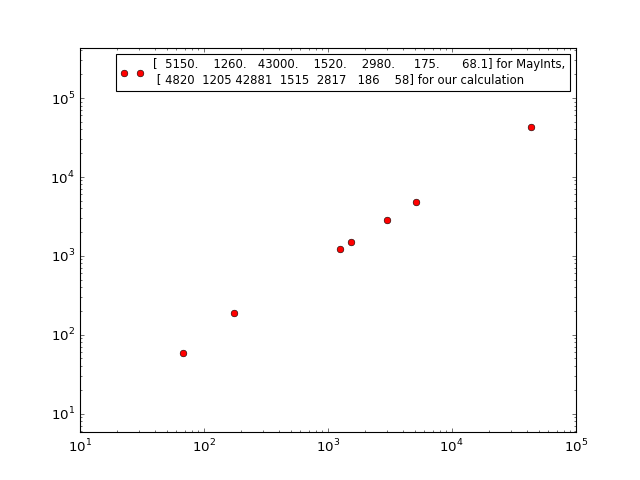

The error of the guesses is 5.37%


In [27]:
# Calculate the intensities using guesses, constants, and the calculated I0
I = intensity_ambmcp(H, K, L, eta, *values.values())

# Plot the intensity of the guesses vs the measured intensities.
plt.plot(MayInts, I, 'ro', label = '{} for MayInts,\n {} for our calculation'.format(MayInts,I.astype(int)))
plt.legend(fontsize = 10.5)
plt.ylim(np.min(I)*.1,np.max(I)*10)
plt.yscale('log')
plt.xscale('log')
print('The error of the guesses is {:.2f}%'.format(np.average(np.abs((np.array(I)-np.array(MayInts))/np.array(MayInts)))*100))

## Setup fit

In [28]:
#Fitting setup
Meas_Ints = np.array((5150, 1260,43000,1520,2980,175, 68.1)) # Measured intensity data

# alpha, beta, gamma, d1, d2, D_1Rppp, D_2Rpmp, D_1Lppm, D_2Rmpp, D_2Rppp, D_1Rpmp, D_2Lppm, D_1Rmpp, D_2Lpmp, D_1Rppm, D_1Lpmp, D_2Rppm 
ifix = [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1] 

# Setup parameters for fit. Also add additional constraints if needed
params = setfix(params,ifix)
params = set_standard_constraints(May_model.make_params(**guesses))
params = set_rotation_domains(params, Rotations)


# If orthohombic only use below. Otherwise will include monoclinic domains as well. 
#params = orthorhombic_only(params,Rotations)

## Run iterative fit

In [29]:
# Begins with guess values then updates to the results of previous iteration. 4 iterations needed to converge to lowest error.

for i in range(10):
    if i != 0:
        guesses.update(result.best_values)
    values = OrderedDict(guesses.items() + constants.items())

    # Get new I0 using fit parameters and constants
    values['I0']=1
    SF_004 = intensity_ambmcp(HH, KK, LL, eta2, *values.values())
    constants['I0'] = I0_cps/SF_004[0]

    # Setup parameters for fit. Also add additional constraints if needed
    params = setfix(params,ifix)
    
    # Run Fit 
    result = May_model.fit(Meas_Ints, H=H, K=K, L=L, eta=eta, params=params, fit_kws={'ftol':1e-8}, **constants)
    #print(result.message)

# Display fitting results and errors
print(result.fit_report())
Ints = result.best_fit
PercentError = np.array(np.abs((Ints-Meas_Ints)/Meas_Ints)*100)
print('Intensity errors are an average of {:.2f}%'.format(np.average(PercentError)))
print('List intensity errors to check for bad peaks: {}'.format(PercentError.astype('int')))

[[Model]]
    Model(intensity_ambmcp)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 7
    # variables        = 4
    chi-square         = 24.409
    reduced chi-square = 8.136
    Akaike info crit   = 16.743
    Bayesian info crit = 16.527
[[Variables]]
    alpha:     6.21906621 +/- 0.002283 (0.04%) (init= 6)
    beta:      6.21906621 +/- 0.002283 (0.04%)  == 'alpha'
    gamma:     6.25741948 +/- 0.005051 (0.08%) (init= 6)
    d1:        0.01493484 +/- 4.45e-06 (0.03%) (init= 0.015)
    d2:        0.00996827 +/- 8.80e-06 (0.09%) (init= 0.01)
    D_1Rppp:   1 (fixed)
    D_2Rpmp:   1 (fixed)
    D_1Lppm:   1 (fixed)
    D_2Rmpp:   1 (fixed)
    D_2Rppp:   0 (fixed)
    D_1Rpmp:   0 (fixed)
    D_2Lppm:   0 (fixed)
    D_1Rmpp:   0 (fixed)
    D_2Lpmp:   0 (fixed)
    D_1Rppm:   0 (fixed)
    D_1Lpmp:   0 (fixed)
    D_2Rppm:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(d1, d2)                    = -0.987 
    C(gamma, d2)           

In [11]:
# If guess is too far off will fail to fit, can change starting values until it works. Is slightly concerning for 
# our purpose. Since it is a SL, the exanded PC unit cell includes both TiO6 and IrO6 octahedra, and 2 TiO6 and 2 IrO6
# for the thick SLs, mixed up. Thus if this model is overly simplified (i.e. assumes uniform rotations) and the 
# intensities do not conform well enough we may not be able to use. Future possiblities are adding a second set of tilt
# angles (alpha2, beta2, gamma2) that are applied for one of the layers along c. Main issue is this could cause a lot 
# of trouble when applied to the 8 possible domains (assuming only a-a-c+ or a-a+c- type rotations, if a mixture it 
# gets even worse) as I am not sure we can uniformly apply the +-+, etc, to both sets of rotations. 
# Will consider in future.